In [ ]:
import os
import random
import time
import heapq
import math
import copy
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Optimal Strategy

In [ ]:
def ship_generator(D, loop_chance=0.5, seed=None):
  if seed:
    random.seed(seed)

  # blocked = 1, open = 0
  ship = np.ones((D, D), dtype=int)

  # picking a random cell in the start and opening it
  start_x, start_y = random.randint(1, D-2), random.randint(1, D-2)
  ship[start_x, start_y] = 0

  # returns valid neighbors (up, down, left, right)
  def neighbors(x, y):
    dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    return [(x+dx, y+dy) for dx, dy in dirs if 0 <= x+dx < D and 0 <= y+dy < D]

  changed = True
  while changed:
    changed = False
    candidates = []
    for i in range(1, D-1):
      for j in range(1, D-1):
        if ship[i, j] == 1:
          open_neighbors = sum(1 - ship[x, y] for x, y in neighbors(i, j))
          if open_neighbors == 1:
              candidates.append((i, j))

    if candidates:
      x, y = random.choice(candidates)
      ship[x, y] = 0
      changed = True

  # identifying the dead ends
  dead_ends = []
  for i in range(1, D-1):
    for j in range(1, D-1):
      if ship[i, j] == 0:
        open_neighbors = [(x, y) for x, y in neighbors(i, j) if ship[x, y] == 0]
        if len(open_neighbors) == 1:
          dead_ends.append((i, j))

  # opening some dead ends to create some loops
  for (x, y) in dead_ends:
    if random.random() < loop_chance:
      closed_neighbors = [(dx, dy) for dx, dy in neighbors(x, y) if ship[dx, dy] == 1]
      if closed_neighbors:
        cx, cy = random.choice(closed_neighbors)
      ship[cx, cy] = 0

  return ship

In [ ]:
def initial_bot_set(ship):
  open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]
  return set(open_cells)

In [ ]:
def move(L, ship, action):
  new_L = set()

  for (i, j) in L:
    ni, nj = i, j

    if action == 'UP' and i > 0 and ship[i-1, j] == 0:
      ni -= 1
    elif action == 'DOWN' and i < ship.shape[0]-1 and ship[i+1, j] == 0:
      ni += 1
    elif action == 'LEFT' and j > 0 and ship[i, j-1] == 0:
      nj -= 1
    elif action == 'RIGHT' and j < ship.shape[1]-1 and ship[i, j+1] == 0:
      nj += 1

    new_L.add((ni, nj))

  return new_L

In [ ]:
def precompute_distances(ship):
  rows, cols = ship.shape

  open_cells = [(i, j) for i in range(rows) for j in range(cols) if ship[i, j] == 0]

  dist_from_to = {}

  # For each open cell, compute shortest distance to all other reachable cells using BFS
  for start in open_cells:
    dist =  {start: 0}
    q = deque([start])

    while q:
      x, y = q.popleft()

      # Explore all 4 possible movement directions (up, down, left, right)
      for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
        nx, ny = x + dx, y + dy

        # Check if new position is valid and unvisited
        if 0 <= nx < rows and 0 <= ny < cols and ship[nx, ny] == 0 and (nx, ny) not in dist:
          dist[(nx, ny)] = dist[(x, y)] + 1
          q.append((nx, ny))

    # After BFS from one start cell, store all computed distances
    for end, d in dist.items():
      dist_from_to[(start, end)] = d

  return dist_from_to

In [ ]:
def manhattan_distance(p1, p2):
  return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# Heuristic function for A*: estimates how far the bot is from localization
def heuristic(L, dist_from_to):
  if len(L) <= 1:
    return 0

  xs = [x for x, _ in L]
  ys = [y for _, y in L]

  # Manhattan span = how far apart the possible cells are in x and y directions
  # This never overestimates the real number of steps, so it's admissible
  return (max(xs) - min(xs)) + (max(ys) - min(ys))

def A_star_strategy(ship, dist_from_to, L, return_path=False, max_expansions=None):
  actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
  start_L = frozenset(L)

  # Priority queue (min-heap) for A*
  # Each entry: (f = g + h, g = cost, L = belief state, sequence = path)
  fringe = []
  heapq.heappush(fringe, (heuristic(start_L, dist_from_to), 0, start_L))

  # Keep track of explored belief states to avoid redundant searches
  visited = set()

  g_cost = {start_L: 0}
  expansions = 0
  parent = {}

  while fringe:
    expansions += 1
    if max_expansions and expansions > max_expansions:
      break

    f, g, L = heapq.heappop(fringe)

    if L in visited:
      continue

    visited.add(L)

    if len(L) == 1:
      if not return_path:
        return g

      sequence = [L]
      while L in parent:
        L = parent[L]
        sequence.append(L)
      sequence.reverse()

      return sequence, g

    # Explore all possible movement actions from current belief
    for action in actions:
      new_L = frozenset(move(L, ship, action))
      g_new = g + 1

      if new_L in visited:
        continue

      if new_L not in g_cost or g_new < g_cost[new_L]:
        g_cost[new_L] = g_new
        parent[new_L] = L
        h_new = heuristic(new_L, dist_from_to)
        f_new = g_new + h_new

        # Push new state into the priority queue with updated path
        heapq.heappush(fringe, (f_new, g_new, new_L))

  # If no localization is possible which happens only if the ship is not a connected map
  if return_path:
    return [start_L], float('inf')
  return float('inf')

In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)

L = initial_bot_set(ship)

dist_from_to = precompute_distances(ship)

moves = A_star_strategy(ship, dist_from_to, L)

print('Number of Moves: ', moves)

Number of Moves:  20


# Input Output Generation

In [ ]:
actions = {
    "UP": (-1, 0),
    "DOWN": (1, 0),
    "LEFT": (0, -1),
    "RIGHT": (0, 1)
}

In [ ]:
def encode_belief(L):
  return tuple(sorted(L))

In [ ]:
def action_valid(action, ship, L):
  new_L = move(L, ship, action)
  return new_L != L

In [ ]:
def generate_input_set(ship, max_depth=8, max_states=1000):
  L0 = initial_bot_set(ship)
  queue = [(L0, 0)]
  visited = {encode_belief(L0)}
  states = []

  while queue:
    L, depth = queue.pop(0)
    states.append(L)

    if max_states is not None and len(states) >= max_states:
      break

    if max_depth is not None and depth >= max_depth:
      continue

    for action in actions:
      if not action_valid(action, ship, L):
        continue

      L1 = move(L, ship, action)
      L1 = frozenset(L1)
      key = encode_belief(L1)

      if key not in visited:
        visited.add(key)
        queue.append((L1, depth + 1))

  return states

In [ ]:
def encode_belief_vector(L, index, N):
  vector = [0] * N
  for cell in L:
    vector[index[cell]] = 1
  return vector

In [ ]:
X_list, Y_list = [], []

open_cells = [(i, j) for i in range(ship.shape[0]) for j in range(ship.shape[1]) if ship[i, j] == 0]
index = {cell: i for i, cell in enumerate(open_cells)}
N = len(open_cells)

bfs_states = generate_input_set(ship)
dataset_states = set()

for L in bfs_states:
  # Add BFS state itself
  dataset_states.add(frozenset(L))

  # Add ALL belief states reachable along optimal A* path from that state
  path, _ = A_star_strategy(ship, dist_from_to, L, return_path=True)
  for belief_state in path:
    dataset_states.add(frozenset(belief_state))

# Convert back to list
states = list(dataset_states)
print("Total unique states:", len(states))

for L in states:
  L = frozenset(L)
  X_val = encode_belief_vector(L, index, N)
  Y_val = A_star_strategy(ship, dist_from_to, L)

  X_list.append(X_val)
  Y_list.append(Y_val)

Total unique states: 4879


In [ ]:
print("num_states:", len(states))
print("num_X:", len(X_list))
print("num_Y:", len(Y_list))

if X_list:
    print("vector length N:", len(X_list[0]))
    print("num_open_cells:", len(open_cells))

num_states: 4879
num_X: 4879
num_Y: 4879
vector length N: 45
num_open_cells: 45


In [ ]:
print(min(Y_list), max(Y_list))
print(Y_list[:20])

0 20
[17, 17, 9, 16, 14, 18, 18, 18, 15, 13, 18, 9, 13, 17, 19, 16, 14, 19, 14, 14]


In [ ]:
sizes = [len(L) for L in states]
print("min belief size:", min(sizes))
print("max belief size:", max(sizes))
print("unique sizes:", sorted(set(sizes)))

min belief size: 1
max belief size: 45
unique sizes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 38, 45]


# Linear Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_list, Y_list, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error:, {mse:.3f}")
print(f"Mean Absolute Error:, {mae:.3f}")
print(f"R-squared:, {r2:.4f}")

Mean Squared Error:, 1.639
Mean Absolute Error:, 0.937
R-squared:, 0.8575


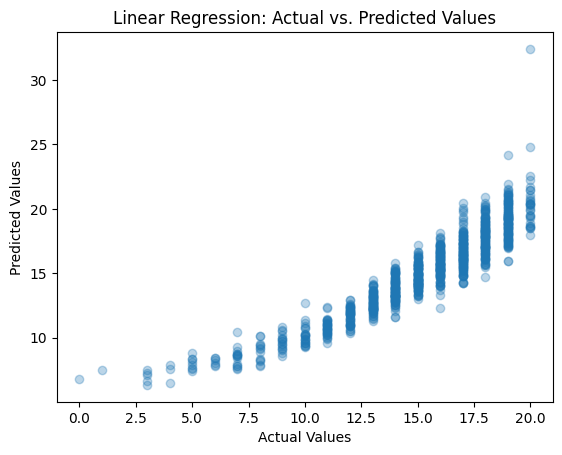

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs. Predicted Values")
plt.show()

# XGBoost

In [ ]:
model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    reg_lambda=1.0,
    reg_alpha=0.0
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error:, {mse:.3f}")
print(f"Mean Absolute Error:, {mae:.3f}")
print(f"R-squared:, {r2:.4f}")

Mean Squared Error:, 0.148
Mean Absolute Error:, 0.230
R-squared:, 0.9872


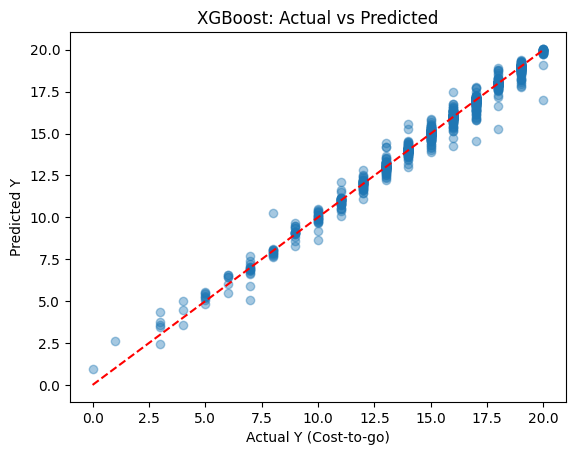

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Y (Cost-to-go)")
plt.ylabel("Predicted Y")
plt.title("XGBoost: Actual vs Predicted")
plt.plot([0,20],[0,20], 'r--')
plt.show()

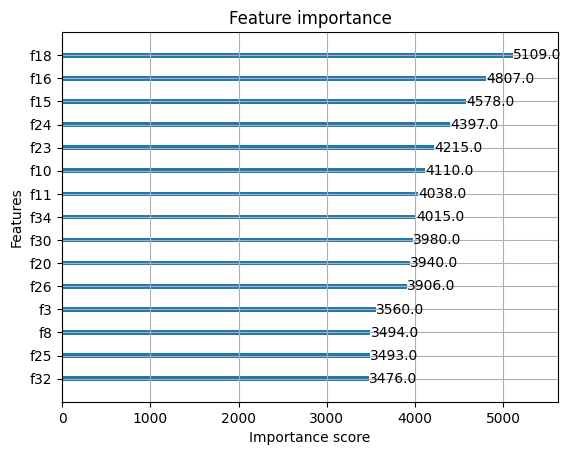

In [ ]:
from xgboost import plot_importance

plot_importance(model, max_num_features=15)
plt.show()

In [ ]:
import pickle

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# A* with XGBoost

In [ ]:
with open('xgboost_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
def encode_belief_wih_model(L, index, N):
  return np.array([encode_belief_vector(L, index, N)])

In [ ]:
def ml_heuristic(L):
  x_vec = encode_belief_wih_model(L, index, N)
  return max(model.predict(x_vec)[0], 0)

In [ ]:
def A_star_strategy_with_model(ship, L):
  actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
  start_L = frozenset(L)
  fringe = []

  heapq.heappush(fringe, (ml_heuristic(start_L), 0, start_L))
  visited = set()

  while fringe:
    f, cost, L = heapq.heappop(fringe)

    if len(L) == 1:
      return cost

    if L in visited:
      continue
    visited.add(L)

    for action in actions:
      new_L = frozenset(move(L, ship, action))
      if new_L in visited:
        continue

      cost_new = cost + 1
      h_new = ml_heuristic(new_L)
      f_new = cost_new + h_new

      heapq.heappush(fringe, (f_new, cost_new, new_L))

  return None

In [ ]:
ship = ship_generator(D=10, loop_chance=0.5, seed=42)

dist_from_to = precompute_distances(ship)

test_states = random.sample(states, 50)

for L in test_states:
  print("Moves using A star using distance heuristic: ", A_star_strategy(ship, dist_from_to, L))
  print("Moves using A star using ML heuristic: ", A_star_strategy_with_model(ship, L))

Moves using A star using distance heuristic:  5
Moves using A star using ML heuristic:  6
Moves using A star using distance heuristic:  19
Moves using A star using ML heuristic:  19
Moves using A star using distance heuristic:  13
Moves using A star using ML heuristic:  13
Moves using A star using distance heuristic:  10
Moves using A star using ML heuristic:  10
Moves using A star using distance heuristic:  13
Moves using A star using ML heuristic:  13
Moves using A star using distance heuristic:  17
Moves using A star using ML heuristic:  17
Moves using A star using distance heuristic:  12
Moves using A star using ML heuristic:  12
Moves using A star using distance heuristic:  16
Moves using A star using ML heuristic:  16
Moves using A star using distance heuristic:  12
Moves using A star using ML heuristic:  12
Moves using A star using distance heuristic:  14
Moves using A star using ML heuristic:  14
Moves using A star using distance heuristic:  19
Moves using A star using ML heuri

In [ ]:
def A_star_count_expansions(ship, L, heuristic_fn):
  actions = ['UP','DOWN','LEFT','RIGHT']
  start_L = frozenset(L)
  visited = set()
  fringe = [(heuristic_fn(start_L), 0, start_L)]
  expansions = 0

  while fringe:
    f, cost, L = heapq.heappop(fringe)

    if len(L) == 1:
      return cost, expansions

    if L in visited:
      continue
    visited.add(L)

    expansions += 1

    for action in actions:
      new_L = frozenset(move(L, ship, action))

      if new_L not in visited:
        h = heuristic_fn(new_L)
        heapq.heappush(fringe, (cost+1 + h, cost+1, new_L))

In [ ]:
for L in random.sample(states, 10):
  cost1, exp1 = A_star_count_expansions(ship, L, lambda L: heuristic(L, dist_from_to))
  cost2, exp2 = A_star_count_expansions(ship, L, ml_heuristic)
  print(cost1, exp1, "|", cost2, exp2)

6 8 | 6 7
16 1436 | 16 82
14 360 | 14 26
13 215 | 13 22
18 2884 | 18 91
12 203 | 12 56
8 31 | 8 22
17 712 | 17 28
13 383 | 13 37
5 8 | 5 5


# Generalization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def encode_map_and_belief(ship, L):
  rows, cols = ship.shape
  X = np.zeros((rows, cols, 2), dtype=np.float32)

  X[:, :, 0] = (ship == 0)

  for (i, j) in L:
    X[i, j, 1] = 1

  return X.reshape(-1)

In [ ]:
ships_set = [ship_generator(D=10, loop_chance=0.5, seed=i) for i in range(20)]

In [ ]:
X_list, Y_list = [], []
cost_cache = {}
path_cache = {}

for ship_id, ship in enumerate(ships_set):
  dist_from_to = precompute_distances(ship)
  bfs_states = generate_input_set(ship, max_states=50)
  dataset_states = set()
  succesfully_processed = 0

  for idx, L in enumerate(bfs_states):
    L = frozenset(L)
    key = (ship_id, L)

    # Processing BFS roots using bounded A star
    path, cost = A_star_strategy(ship, dist_from_to, L, return_path=True, max_expansions=5000)

    if cost == float('inf'):
      continue

    succesfully_processed += 1

    path_cache[key] = path

    # Extracting training labels from optimal paths
    for i, belief_state in enumerate(path_cache[key]):
      bL = frozenset(belief_state)
      cost_cache[(ship_id, bL)] = max(cost - i, 0)
      dataset_states.add(bL)

  # Encoding final dataset
  for L in dataset_states:
    key = (ship_id, L)

    X_list.append(encode_map_and_belief(ship, L))
    Y_list.append(cost_cache[key])

print("FINAL DATASET")
print("Total samples:", len(X_list), len(Y_list))
print("Y range:", min(Y_list), max(Y_list))
print("X shape:", X_list[0].shape)

FINAL DATASET
Total samples: 3095 3095
Y range: 0 19
X shape: (200,)


In [ ]:
# Converting the dataset into tensors and creating data loaders for min batch training
X = torch.from_numpy(np.stack(X_list).reshape(-1, 2, 10, 10)).float()
Y = torch.from_numpy(np.array(Y_list)).float()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class Belief_CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)

    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(64 * 2 * 2, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)

  def forward(self, x):
    # First convolutional block with two 3 * 3 convolutional layers with ReLU activations and max pooing
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    # Flatten layer
    x = x.flatten(1)

    # Fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
# Training the model using Adam optimizer and mean squared error
model = Belief_CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(20):
  model.train()
  total_loss = 0

  for X_batch, Y_batch in train_loader:
    optimizer.zero_grad()
    pred = model(X_batch.float()).flatten()
    loss = criterion(pred, Y_batch.float())
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 37.71942494465755
Epoch 2, Loss: 9.006473171405304
Epoch 3, Loss: 3.2548184455969396
Epoch 4, Loss: 2.7261256957665467
Epoch 5, Loss: 2.1872914662727942
Epoch 6, Loss: 1.882321100204419
Epoch 7, Loss: 1.4545552340837626
Epoch 8, Loss: 1.156455846169056
Epoch 9, Loss: 1.0370273635937617
Epoch 10, Loss: 1.0277002132855928
Epoch 11, Loss: 0.9513592804089571
Epoch 12, Loss: 0.8439425138326792
Epoch 13, Loss: 1.0895670728805738
Epoch 14, Loss: 0.727488576219632
Epoch 15, Loss: 0.6660680404076209
Epoch 16, Loss: 0.6877002311058533
Epoch 17, Loss: 0.6354639278008387
Epoch 18, Loss: 0.6341344381754215
Epoch 19, Loss: 0.5707673010153648
Epoch 20, Loss: 0.49998377569210833


In [ ]:
# Evaluating the model and performing forward pass over validation data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for X_batch, Y_batch in val_loader:
    pred = model(X_batch.float()).flatten()
    all_preds.append(pred.cpu())
    all_labels.append(Y_batch.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

In [ ]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error:, {mae:.3f}")
print(f"Mean Squared Error:, {mse:.3f}")
print(f"R-squared:, {r2:.4f}")

Mean Absolute Error:, 0.594
Mean Squared Error:, 0.559
R-squared:, 0.9741


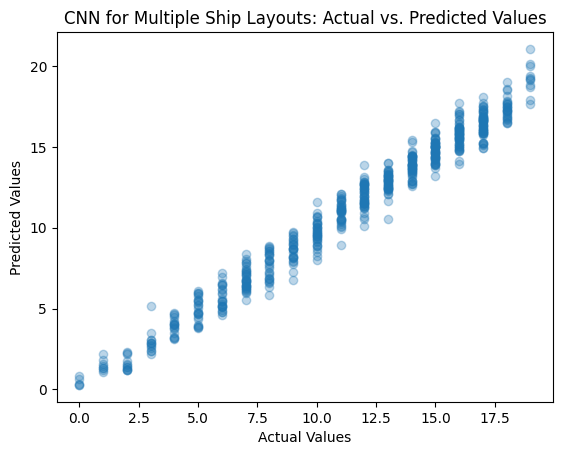

In [ ]:
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("CNN for Multiple Ship Layouts: Actual vs. Predicted Values")
plt.show()